In [2]:
import itertools
import json
import pandas as pd
import numpy as np
import datetime
from prophet import Prophet
from prophet.serialize import model_to_json
from prophet.diagnostics import cross_validation, performance_metrics

In [3]:
# --- FUNZIONI DI SUPPORTO

# ritorna un oggetto datetime a partire da un timestamp nel formato 
# "YYYY-MM-DD HH:MM:SS"
def timestamp_to_datetime(timestamp):
  year, month, day = timestamp.split(" ")[0].split("-")
  hour, minute, second = timestamp.split(" ")[1].split(":")
  date = datetime.datetime(
    int(year), int(month), int(day), 
    int(hour), int(minute), int(second)
  )

  return date

# from_date: datetime che rappresenta data e ora a partire dalle quali sono generati i timestamp
# periods: il numero di giorni per cui si vogliono generare date
# interval_mins: intervallo tra due timestamp successivi (in minuti)
def make_future_dataframe(from_date, periods, interval_mins):
  timestamps = []
  MINUTES_PER_DAY = 1440
  n_samples = (MINUTES_PER_DAY // interval_mins) * periods
  
  for i in range(1, n_samples + 1):
    from_date += datetime.timedelta(minutes=interval_mins)
    timestamps.append(str(from_date))

  return pd.DataFrame({ 'ds': timestamps })

# Caricamento e preprocessing del dataset

In [4]:
feed = "location-1"
timezone = "UTC"

# caricamento dei dati del feed e preprocessing
feed_data = pd.read_csv(feed + ".csv", sep=";")
feed_data = feed_data.loc[:, ["created_at", "value"]]
feed_data["created_at"] = \
  feed_data["created_at"].apply(lambda x: x.replace(" " + timezone, ""))

feed_data

,created_at,value
0,2021-11-29 00:00:00,0
1,2021-11-29 00:30:00,0
2,2021-11-29 01:00:00,0
3,2021-11-29 01:30:00,0
4,2021-11-29 02:00:00,0
...,...,...
5035,2022-03-13 21:30:00,31
5036,2022-03-13 22:00:00,30
5037,2022-03-13 22:30:00,30
5038,2022-03-13 23:00:00,30


In [5]:
feed_data.columns = ["ds", "y"]

# Selezione dei parametri del modello

In [7]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
scores = []

# Use cross validation to evaluate all parameters
for params in all_params:
    model = Prophet(**params).fit(feed_data)  # Fit model with given params
    df_cv = cross_validation(model, initial='70 days', period='7 days', horizon = '14 days', parallel="processes")
    df_p = performance_metrics(df_cv)
    scores.append(df_p['rmse'].values[0])

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Making 3 forecasts with cutoffs between 2022-02-13 23:30:00 and 2022-02-27 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f45b9cc3c50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Making 3 forecasts with cutoffs between 2022-02-13 23:30:00 and 2022-02-27 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f45b9cb0dd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Making 3 forecasts with cutoffs between 2022-02-13 23:30:00 and 2022-02-27 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f45b92fbb50>
INFO:prophet:Disabling yearly seasonality. Run prophet with year

In [8]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = scores
tuning_results

,changepoint_prior_scale,seasonality_prior_scale,rmse
0,0.001,0.01,2.087801
1,0.001,0.10,2.103632
2,0.001,1.00,2.122714
3,0.001,5.00,2.118875
4,0.001,10.00,2.132060
5,0.010,0.01,1.558811
6,0.010,0.10,1.549594
7,0.010,1.00,1.546419
8,0.010,5.00,1.543092
9,0.010,10.00,1.545446


In [10]:
best_params = \
  tuning_results[tuning_results['rmse'] == tuning_results['rmse'].min()]

# changepoint_prior_scale = 0.5, seasonality_prior_scale = 5
best_params

,changepoint_prior_scale,seasonality_prior_scale,rmse
18,0.5,5.0,1.440376


In [11]:
best_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'], 
    seasonality_prior_scale=best_params['seasonality_prior_scale']
)

best_model.fit(feed_data)

# salvataggio del modello su json
with open(f'{ feed }.json', 'w') as fout:
    json.dump(model_to_json(best_model), fout)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


# Verifica del fitting del modello sui prossimi 14 giorni

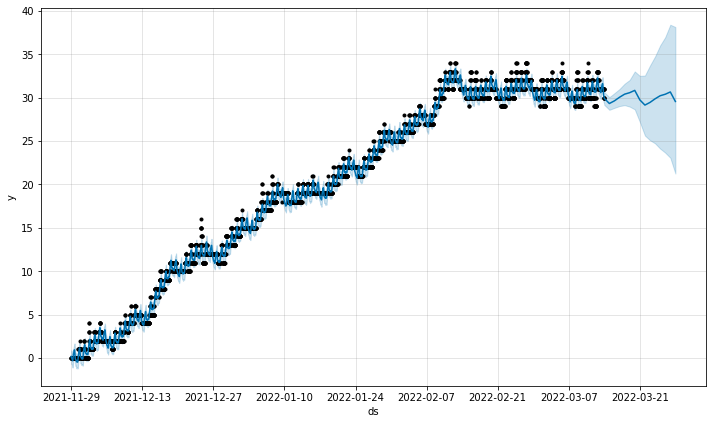

In [13]:
future = best_model.make_future_dataframe(periods=14)
forecast = best_model.predict(future)
best_model.plot(forecast)
pass

# Predizioni dei prossimi 7 giorni



In [14]:
periods = 7
from_date = timestamp_to_datetime(feed_data.loc[feed_data.shape[0] - 1, 'ds'])
future = make_future_dataframe(from_date, periods, interval_mins=30)
future

,ds
0,2022-03-14 00:00:00
1,2022-03-14 00:30:00
2,2022-03-14 01:00:00
3,2022-03-14 01:30:00
4,2022-03-14 02:00:00
...,...
331,2022-03-20 21:30:00
332,2022-03-20 22:00:00
333,2022-03-20 22:30:00
334,2022-03-20 23:00:00


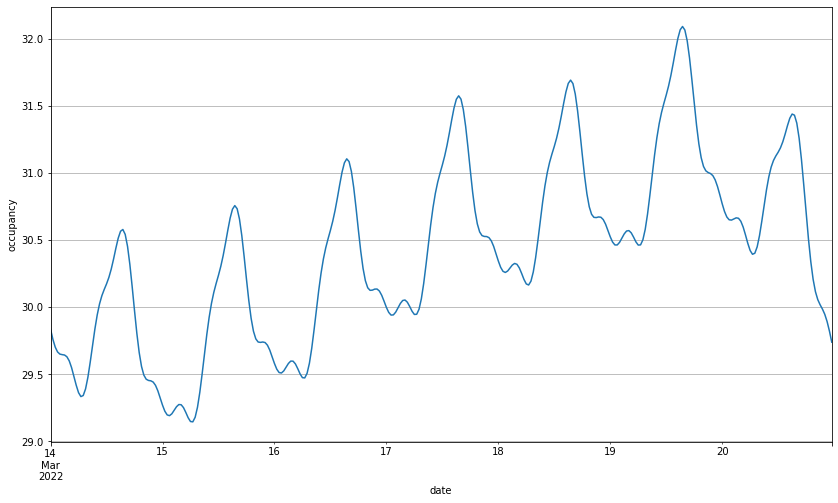

In [15]:
forecast = best_model.predict(future)
forecast.plot(
    figsize=(14, 8),
    x='ds', xlabel='date', 
    y='yhat', ylabel='occupancy',
    legend=False, grid=True, 
)

pass